# Create Function to Plot Conductors
Need to grab conductor data from Warp instance or pickle'd data and automatically plot conductors.

In [1]:
% matplotlib notebook

In [2]:
from __future__ import division
import sys
import time
del sys.argv[1:] #  Necessry to run 'from warp import *' in IPython notebook without conflict.
from warp import * 
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle
from re import findall
from datetime import datetime
from scipy.special import erfinv
from warp.data_dumping.openpmd_diag import ParticleDiagnostic
from rswarp.diagnostics import FieldDiagnostic
from rswarp.utilities.file_utils import cleanupPrevious
from warp.particles.singleparticle import TraceParticle

# Warp
# Origin date: Wed, 5 Apr 2017 19:58:44 +0000
# Local date: Wed, 5 Apr 2017 19:58:44 +0000
# Commit hash: 10722e8
# /usr/local/lib/python2.7/site-packages/warp/warp.pyc
# /usr/local/lib/python2.7/site-packages/warp/warpC.so
# Wed Apr 26 11:47:27 2017
# import warp time 0.293545007706 seconds
# For more help, type warphelp()


In [3]:
# Plotting imports
import matplotlib.animation as anim
import matplotlib.lines as mlines
import types
import matplotlib as mpl
from matplotlib import gridspec
import matplotlib.patches as patches
import h5py

# Constants imports
from scipy.constants import e, m_e, c, k
kb_eV = 8.6173324e-5 #Bolztmann constant in eV/K
kb_J = k #Boltzmann constant in J/K
m = m_e

# Diagnostic Directories

In [4]:
diagDir = 'diags/xzsolver/hdf5'
field_base_path = 'diags/fields/'
child0_cathode_dir = 'diags/fields/child0_cathode'
child0_anode_dir = 'diags/fields/child0_anode'
diagFDir = {'magnetic': field_base_path + 'magnetic','electric':field_base_path + 'electric', 
            'child0_cathode': child0_cathode_dir, 'child0_anode': child0_anode_dir}

# Cleanup previous files
cleanupPrevious(diagDir,diagFDir)

# Grid Parameters

In [5]:
#GLOBAL USER PARAMETERS

#Injection strategy
top.inject = 0               # 1 means constant; 2 means space-charge limited injection; 4 means thermionic;
                             # 6 means user-specified; 5 and 8 are balances between thermionic and SC-limited


GRID_VOLTAGE = 60.0
ANODE_VOLTAGE = 0.
GRID_VOLTAGE_0 = -2.0

#Dimensions
PLATE_SPACING = 100e-6 #plate spacing
CHANNEL_WIDTH = 100e-6 #width of simulation box

X_MAX = CHANNEL_WIDTH*0.5
X_MIN = -1.*X_MAX
Y_MAX = CHANNEL_WIDTH*0.5
Y_MIN = -1.*Y_MAX
Z_MIN = 0.
Z_MAX = PLATE_SPACING

# Grid parameters (Parent Grid)
NUM_X = 100 
NUM_Y = 1
NUM_Z = 100 

print("Cells along X: {}\n\v Cell size X: {} nm".format(NUM_X,CHANNEL_WIDTH / NUM_X * 1e9))
print("Cells along Z: {}\n\v Cell size Z: {} nm".format(NUM_Z,PLATE_SPACING / NUM_Z * 1e9))

Cells along X: 100
 Cell size X: 1000.0 nm
Cells along Z: 100
 Cell size Z: 1000.0 nm


# Solver Geometry

In [6]:
w3d.solvergeom = w3d.XZgeom

# Grid and Boundary Conditions

In [7]:
# Set boundary conditions
# Longitudinal conditions overriden by conducting plates
w3d.bound0  = neumann
w3d.boundnz = dirichlet
w3d.boundxy = periodic 
# Particles boundary conditions
top.pbound0  = absorb
top.pboundnz = absorb
top.pboundxy = periodic

# Set grid boundaries
w3d.xmmin = X_MIN
w3d.xmmax = X_MAX
w3d.ymmin = Y_MIN
w3d.ymmax = Y_MAX
w3d.zmmin = 0. 
w3d.zmmax = Z_MAX

# Set grid counts
w3d.nx = NUM_X
w3d.ny = NUM_Y
w3d.nz = NUM_Z

zmesh = np.linspace(0,Z_MAX,NUM_Z+1) #holds the z-axis grid points in an array

# Field Solver

In [8]:
# Set up fieldsolver
f3d.mgtol = 1e-3 # Multigrid solver convergence tolerance, in volts. 1 uV is default in Warp.
solverE = MultiGrid2D()
registersolver(solverE)
# solverE.mgverbose = -1 # Don't print solver convergence information

# Conducting boundaries and Scrapers  

These must be installed after registering the field solver.

In [9]:
# Grid test options
# 0: Single box with positive voltage
# 1: Rows and columns of conducting squares

grid = 1

In [10]:
if not grid:
    cond = Box(CHANNEL_WIDTH / 2., 10., PLATE_SPACING / 2., 
               xcent=0.,  
               ycent=0., 
               zcent=PLATE_SPACING / 2.,
               voltage=10.)
    solverE.installconductor(cond)    

if grid:
    col = 5
    row = 5
    for i in range(col):
        for j in range(row):
            cond = Box(CHANNEL_WIDTH / col * 0.75, 10., PLATE_SPACING / row * 0.75, 
                       xcent=CHANNEL_WIDTH * (i + 1) / col - CHANNEL_WIDTH / 2. - CHANNEL_WIDTH / col / 2.,  
                       ycent=0., 
                       zcent=PLATE_SPACING * (j + 1) / row - PLATE_SPACING / row / 2.,
                       voltage=(i - j) * (-1.)**(i))
            solverE.installconductor(cond)

# Particle, Lost Particle, and Field Diagnostics

In [11]:
# Field Diagnostics
fieldperiod = 100
efield_diagnostic_0 = FieldDiagnostic.ElectrostaticFields(solver=solverE, top=top, w3d=w3d,
                                                          write_dir=field_base_path + 'electric',
                                                          comm_world=comm_world, period=fieldperiod)
installafterstep(efield_diagnostic_0.write)

# Generate PIC code and Run Simulation

In [12]:
# prevent GIST from starting upon setup
top.lprntpara = False
top.lpsplots = False

# top.verbosity = 0 # Reduce solver verbosity 
package("w3d")
generate()

 ***  particle simulation package W3D generating
 ---  Resetting lattice array sizes
 ---  Allocating space for particles
 ---  Loading particles
 ---  Setting charge density
 ---  done
 ---  Allocating Win_Moments
 ---  Allocating Z_Moments
 ---  Allocating Lab_Moments
Multigrid2d: Error converged to   8.923E-04 in    19 v-cycles           
it =      0 time = 0.0000E+00 pz = 0.0000E+00 ese = 0.0000E+00 ek = 0.0000E+00 et = 0.0000E+00


In [13]:
step(1)

 ***  particle simulation package W3D running
Multigrid2d: Error converged to   5.761E-04 in     1 v-cycles           
it =      1 time = 0.0000E+00 pz = 0.0000E+00 ese = 0.0000E+00 ek = 0.0000E+00 et = 0.0000E+00


# Analysis

# Conductor Positions/Sizes

In [14]:
print_attr = False

if print_attr:
    for cond in solverE.installedconductorlists[0.0]:
        print cond
        print "xcent:", cond.xcent 
        try:
            print "xsize:", cond.xsize
        except AttributeError:
            print
        print "zcent:", cond.zcent
        try:
            print "zsize:", cond.zsize
        except AttributeError:
            print 

In [15]:
print_types = False

if print_types:
    for cond in solverE.installedconductorlists[0.0]:
        print type(cond)
        print cond.voltage
        print type(cond) is 'warp.field_solvers.generateconductors.ZPlane'
        print isinstance(cond, getattr(field_solvers.generateconductors, "ZPlane"))

In [16]:
sys.path.append('/Users/chall/research/github/rswarp/rswarp/utilities/')

from conductor_plot import PlotConductors

In [17]:
test = PlotConductors()

In [18]:
test.conductor_coordinates(solverE)

<IPython.core.display.Javascript object>


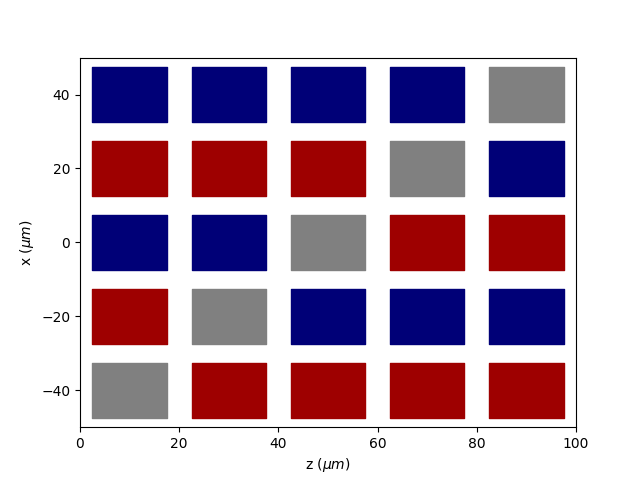

In [19]:
test.create_artist()
test.conductor_collection()